# Проект: Статистический анализ данных  

Мы аналитики популярного сервиса аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти. 
  
Сначала мы проведём предобработку данных, изменив типы столбцов, где это необходимо, а также проверив и обработав пропущенные значения и дубликаты. Затем проведём исследовательский анализ данных, изучив частоту встречаемости городов, соотношения пользователей с подпиской и без, их возраст, расстояние и время их поездок. Зачем объединим все данные в один датафрейм, чтобы собрать всю информацию по пользователям для дальнейшего анализа, в частности подсчёта ежемесячной выручки. И в конце проверим гипотезы, которые помогут менеждерам увеличить число пользователей с подпиской.

Импортируем необходимые для проекта библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

from scipy.stats import binom
from math import sqrt

## Загрузка данных

Считываем CSV-файлы с исходными данными и сохраняем их в датафреймы.  
  
У нас есть информация о пользователях, их поездках и подписках.  
Выведем первые строки каждого набора данных и изучим общую информацию о каждом датафрейме.

**Информация о пользователях:**

In [2]:
users = pd.read_csv('/Users/dmitrynikolaev/Documents/datasets/users_go.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Столбцы: user_id - уникальный идентификатор пользователя, name - имя пользователя, age - возраст, city - город, subscription_type - тип подписки (free, ultra).  
1565 строк, пропущенных значений нет

In [3]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


---
**Информация о поездках:**

In [4]:
rides = pd.read_csv('/Users/dmitrynikolaev/Documents/datasets/rides_go.csv')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Столбцы: user_id - уникальный идентификатор пользователя, distance - расстояние, которое пользователь проехал в текущей сессии (в метрах), duration - продолжительность сессии в минутах, date - дата совершения поездки (этот столбец позже приведём к datetime).  
18068 строк, пропущенных значений нет

In [5]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


---
**Информация о подписках:**

In [6]:
subscriptions = pd.read_csv('/Users/dmitrynikolaev/Documents/datasets/subscriptions_go.csv')
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Столбцы: subscription_type - тип подписки, minute_price - стоимость одной минуты поездки по данной подписке, start_ride_price - стоимость начала поездки, subscription_fee - стоимость ежемесячного платежа.  
2 строки, пропущенных значений нет

In [7]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


С данными познакомились, приступим к предобработке.

## Предобработка данных

### Приведём столбец date к типу даты pandas

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


### Создадим новый столбец с номером месяца на основе столбца date и проверим результат

In [9]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [10]:
print('Имеем данные по поездкам  за период с', rides['date'].min(), 'по', rides['date'].max())

Имеем данные по поездкам  за период с 2021-01-01 00:00:00 по 2021-12-30 00:00:00


То есть за 12 месяцев 2021ого года.

### Проверим наличие пропущенных значений и дубликатов в датафреймах. Обработаем их, если такие значения присутствуют  
  
Отсутствие пропусков проверили раньше, проверим дубликаты в данных по пользователям и по поездкам:

In [11]:
users.duplicated().sum()

31

В таблице с пользователями есть дубликаты, удалим их и проверим размер обновлённой таблицы

In [12]:
users = users.drop_duplicates()
users.shape

(1534, 5)

In [13]:
rides.duplicated().sum()

0

В итоге в таблице с данными по пользователям удалили 31 дубликат, в информации по поездкам дубликатов нет.

## Исследовательский анализ данных

**Опишем и визуализируем общую информацию о пользователях и поездках:** 

### Частота встречаемости городов

In [14]:
users['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

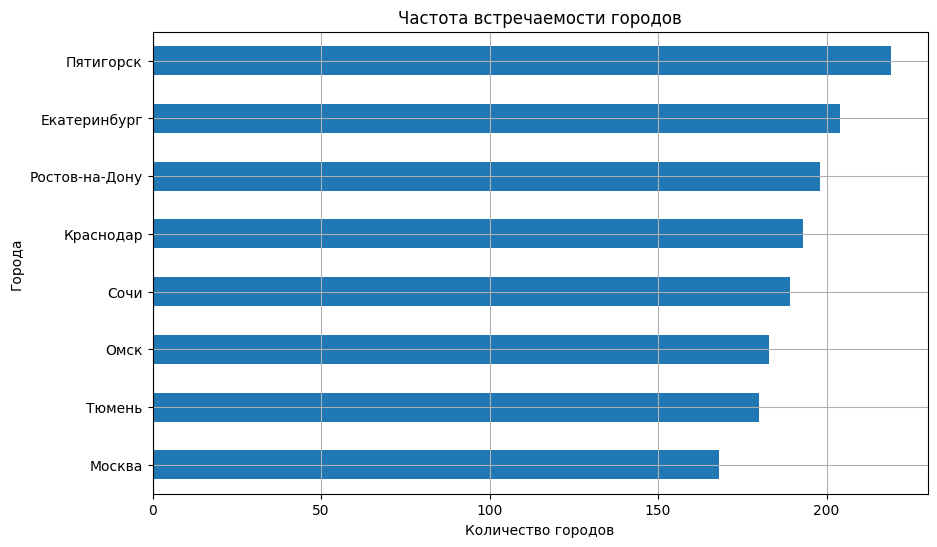

In [15]:
users['city'].value_counts().sort_values(ascending=True).plot.barh(figsize=(10,6), grid=True)
plt.title("Частота встречаемости городов")
plt.xlabel("Количество городов")
plt.ylabel("Города")
plt.show()

По сводной таблице и диаграмме видим, что в данных представлено 8 городов, чаще встречается Пятигорск и Екатеринбург, реже Тюмень и Москва. Но в целом разброс между всеми городами небольшой, около 50 пользователей.

### Cоотношение пользователей с подпиской и без подписки

In [16]:
users['subscription_type'].value_counts() 

subscription_type
free     835
ultra    699
Name: count, dtype: int64

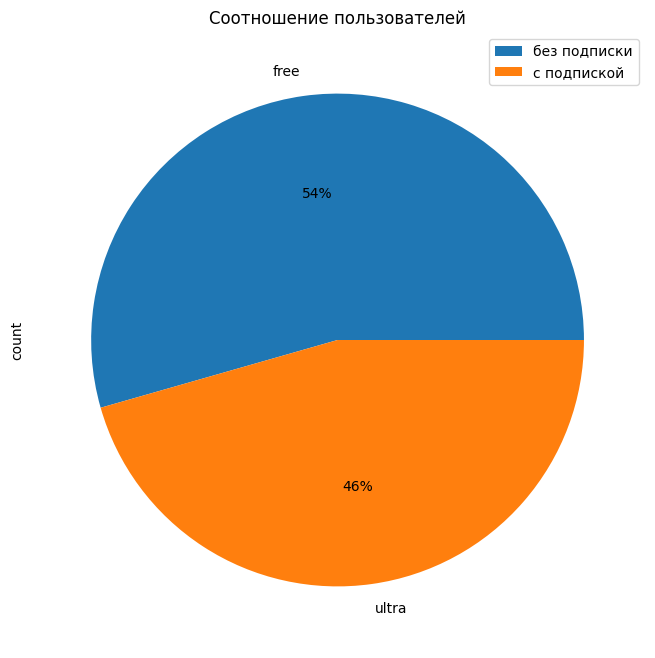

In [17]:
users['subscription_type'].value_counts().plot(kind='pie', figsize=(8,8), autopct='%1.0f%%')
plt.legend(['без подписки','с подпиской'])
plt.title("Соотношение пользователей")
plt.show()

Пользователей без подписки немного больше, чем с ней - 54% против 46%.

### Возраст пользователей

In [18]:
users['age'].value_counts()

age
25    145
24    132
26    131
23    129
22    119
27    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: count, dtype: int64

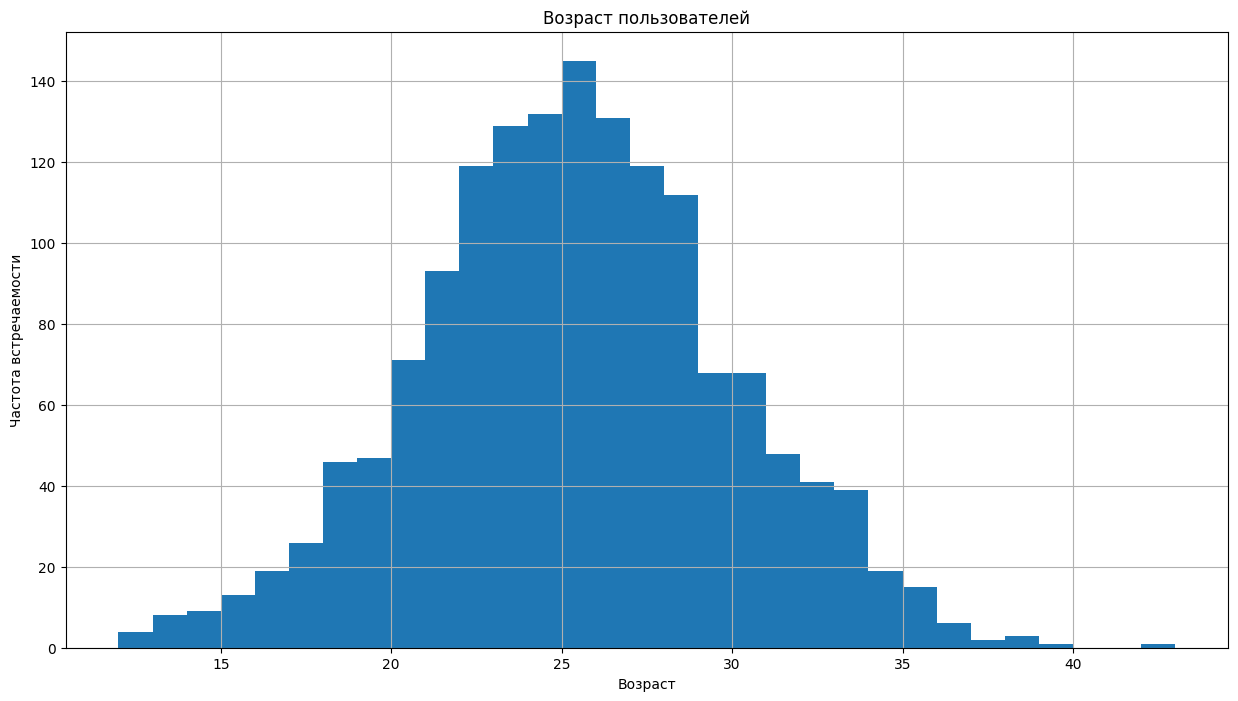

In [19]:
users['age'].hist(bins=31, figsize=(15,8))
plt.title("Возраст пользователей")
plt.xlabel("Возраст")
plt.ylabel("Частота встречаемости")
plt.show()

In [20]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Больше всего пользователей около 25 лет и в целом молодёжи от 20 до 30 лет, минимальный возраст 12 лет, максимальный 43.

### Расстояние, которое пользователь преодолел за одну поездку

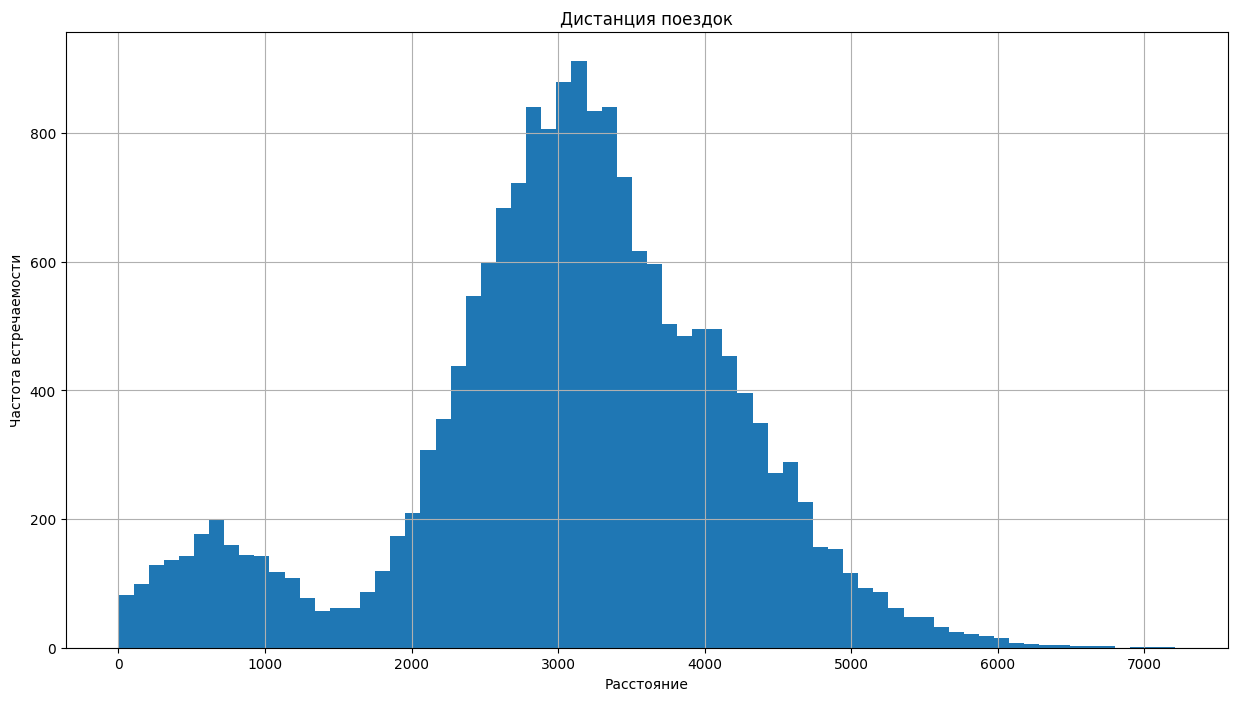

In [21]:
rides['distance'].hist(bins=70, figsize=(15,8))
plt.title("Дистанция поездок")
plt.xlabel("Расстояние")
plt.ylabel("Частота встречаемости")
plt.show()

Видим, что немного популярны короткие поездки на 600-700 метров, а самые распространённые - около 3х километров. Можно предположить, что короткие поездки совершают для пересадки на другой транспорт, например на метро, или для поездок по району, а длинные поездки это уже, скажем так, от и до, без пересадок.

### Продолжительность поездок

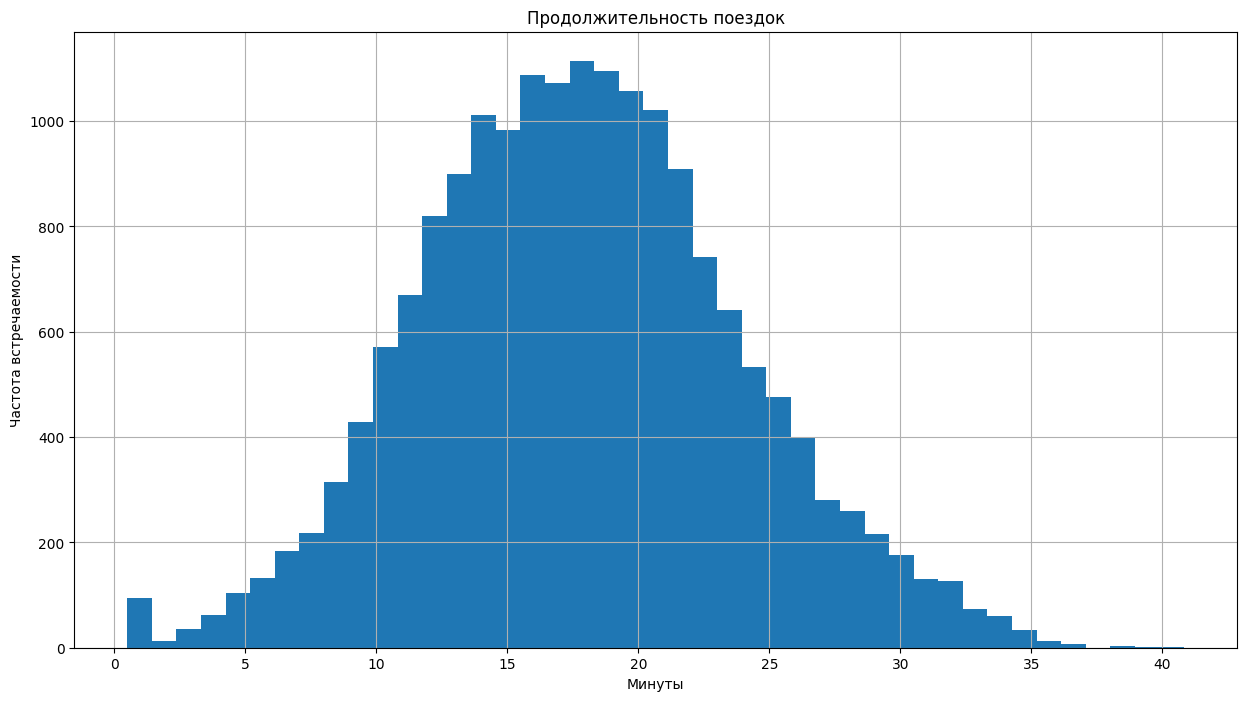

In [22]:
rides['duration'].hist(bins=43, figsize=(15,8))
plt.title("Продолжительность поездок")
plt.xlabel("Минуты")
plt.ylabel("Частота встречаемости")
plt.show()

Чаще всего самокаты арендуют для поездок на 15-20 минут. Пик около нулевого значения опишем позже, когда разделим пользователей по типу подписки.

## Объединение данных

### Объединим данные о пользователях, поездках и подписках в один датафрейм. 

In [23]:
data = users.merge(rides, on='user_id', how='left')
data = data.merge(subscriptions, on='subscription_type', how='left')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Получили одну большую таблицу с информацией о пользователях, их поездках и подписке.  
Количество строк в новой таблице такое же, как в исходной, ничего не потеряли и лишнего не добавили, пропусков нет.

### Создадим ещё два датафрейма из датафрейма, созданного на предыдущем этапе:
c данными о пользователях без подписки и с данными о пользователях с подпиской

In [24]:
users_free = data[data['subscription_type']=='free'] # без подписки
users_free.reset_index(drop=True, inplace=True) # сбросим индексы в новой таблице
users_free.info()
users_free.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11568 entries, 0 to 11567
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int32         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.0+ MB


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [25]:
users_ultra = data[data['subscription_type']=='ultra'] # с подпиской
users_ultra.reset_index(drop=True, inplace=True) # сбросим индексы в новой таблице
users_ultra.info()
users_ultra.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int32         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 584.1+ KB


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Разделили пользователей по типу подписки.

### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

Информация о расстоянии поездок

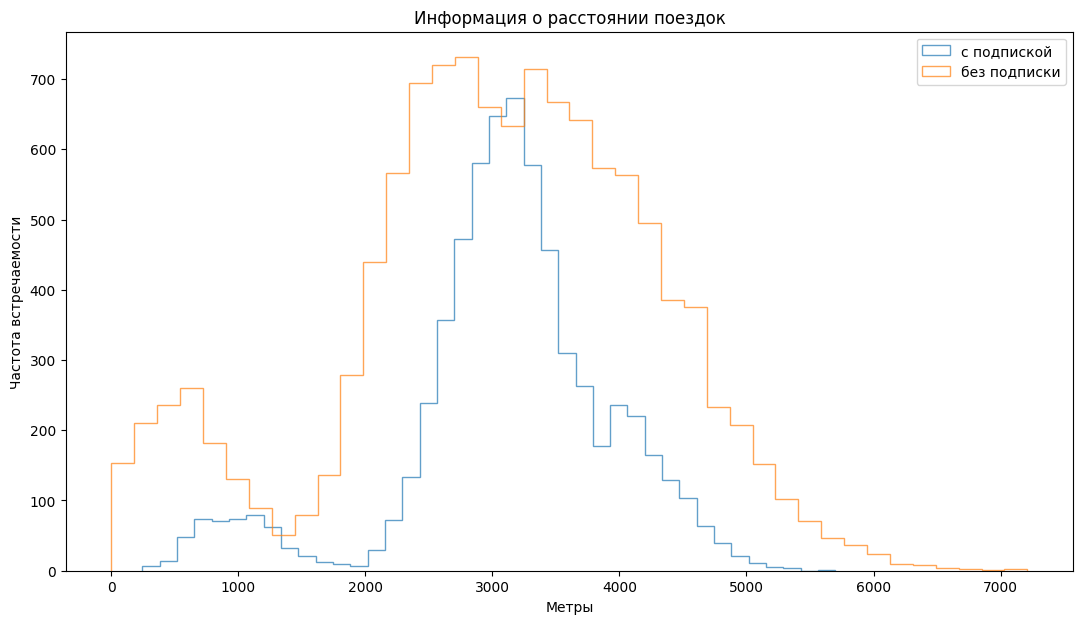

In [26]:
ax = users_ultra['distance'].plot(kind='hist', bins=40, histtype='step', alpha=0.7, figsize=(13,7))
users_free['distance'].plot(kind='hist', bins=40, histtype='step', ax=ax, alpha=0.7, figsize=(13,7))
plt.legend(['с подпиской','без подписки'])
plt.title("Информация о расстоянии поездок")
plt.xlabel("Метры")
plt.ylabel("Частота встречаемости")
plt.show()

Информация о длительность поездок

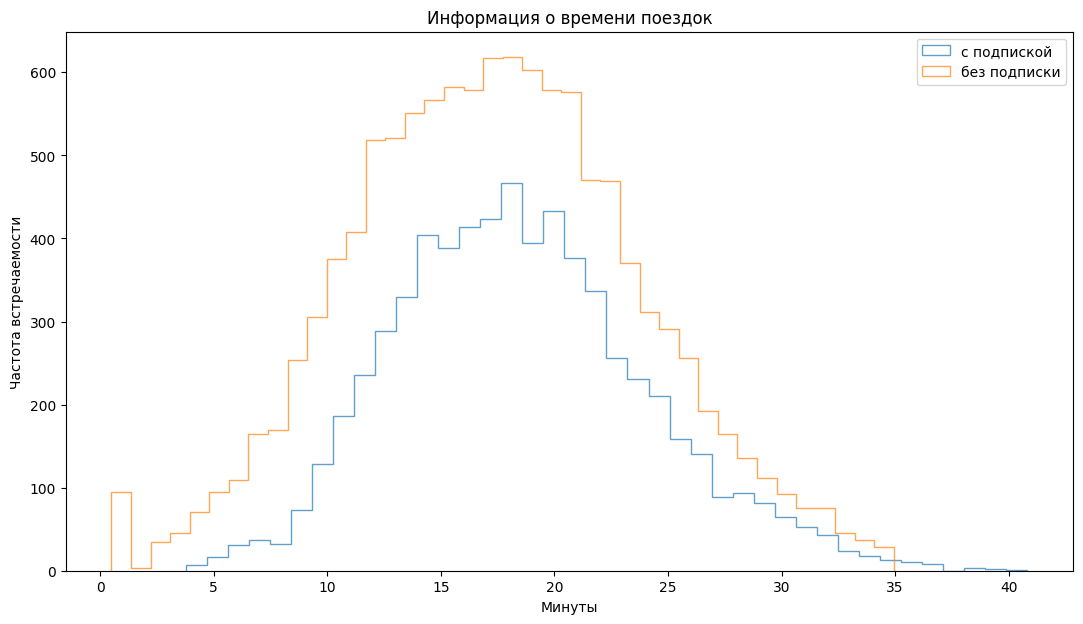

In [27]:
ax = users_ultra['duration'].plot(kind='hist', bins=40, histtype='step', alpha=0.7, figsize=(13,7))
users_free['duration'].plot(kind='hist', bins=40, histtype='step', ax=ax, alpha=0.7, figsize=(13,7))
plt.legend(['с подпиской','без подписки'])
plt.title("Информация о времени поездок")
plt.xlabel("Минуты")
plt.ylabel("Частота встречаемости")
plt.show()

Видим, что графики расстоянии и времени поездок похожи, разве что первая мода расстояния у пользователей с подпиской сдвинута ближе к километру, против 600-700 метров - без подписки.

In [28]:
users_free[users_free['duration']<3].head(10) # выведем 10 поездок длительностью менее 3х минут

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
31,701,Иван,31,Екатеринбург,free,4196.445201,0.500000,2021-08-31,8,8,50,0
70,704,Мирон,29,Ростов-на-Дону,free,4830.824371,0.500000,2021-10-14,10,8,50,0
180,712,Дарья,28,Москва,free,4684.004397,0.500000,2021-03-04,3,8,50,0
191,712,Дарья,28,Москва,free,23.963062,2.053251,2021-11-22,11,8,50,0
195,713,Святослав,30,Краснодар,free,5215.642710,0.500000,2021-02-25,2,8,50,0
268,718,Владислава,31,Москва,free,5197.436649,0.500000,2021-02-11,2,8,50,0
301,720,Сергей,25,Тюмень,free,102.323624,2.292353,2021-09-20,9,8,50,0
360,724,Елизавета,23,Краснодар,free,6225.520342,0.500000,2021-12-16,12,8,50,0
383,726,Ольга,22,Пятигорск,free,4452.491518,0.500000,2021-03-01,3,8,50,0
518,735,Кирилл,18,Пятигорск,free,4406.954812,0.500000,2021-04-13,4,8,50,0


 Также у пользователей без подписки видим много поездок с длительностью в полминуты, но с достаточно большими дистанциями, что можно объяснить либо сбоями, либо, возможно, таким образом была реализована какая-нибудь акция с бесплатными минутами и эти поездки всё равно нужно учитывать при расчете выручки.

## Подсчёт выручки

### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

Сначала округлим минуты поездки в большую сторону

In [29]:
data['duration'] = np.ceil(data['duration'])

In [30]:
data_month = data.groupby(['user_id','month'], as_index=False)\
            .agg({'distance': ['sum', 'count'], 'duration': 'sum'})
data_month.head(10)

user_id month      distance       duration
                          sum count      sum
0       1     1   7027.511294     2     42.0
1       1     4    754.159807     1      7.0
2       1     8   6723.470560     2     46.0
3       1    10   5809.911100     2     32.0
4       1    11   7003.499363     3     56.0
5       1    12   6751.629942     2     28.0
6       2     3  10187.723006     3     63.0
7       2     4   6164.381824     2     40.0
8       2     6   3255.338202     1     14.0
9       2     7   6780.722964     2     48.0

Мультиназвания столбцов переименуем в более привычные

In [31]:
data_month.columns

MultiIndex([( 'user_id',      ''),
            (   'month',      ''),
            ('distance',   'sum'),
            ('distance', 'count'),
            ('duration',   'sum')],
           )

In [32]:
data_month.columns=['user_id','month','sum_distance','count_rides','sum_duration']
data_month.head()

,user_id,month,sum_distance,count_rides,sum_duration
0,1,1,7027.511294,2,42.0
1,1,4,754.159807,1,7.0
2,1,8,6723.470560,2,46.0
3,1,10,5809.911100,2,32.0
4,1,11,7003.499363,3,56.0


### В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки.

Сначала добавим в новую таблицу столбцы с типом подписки для каждого пользователя и информацию по ней.

In [33]:
data_month = data_month.merge(users[['user_id','subscription_type']], on='user_id', how='left')

In [34]:
data_month = data_month.merge(subscriptions, on='subscription_type', how='left')

In [35]:
data_month.head()

,user_id,month,sum_distance,count_rides,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,2,42.0,ultra,6,0,199
1,1,4,754.159807,1,7.0,ultra,6,0,199
2,1,8,6723.470560,2,46.0,ultra,6,0,199
3,1,10,5809.911100,2,32.0,ultra,6,0,199
4,1,11,7003.499363,3,56.0,ultra,6,0,199


In [36]:
data_month['income'] = data_month['count_rides']*data_month['start_ride_price']+ \
                        data_month['sum_duration']*data_month['minute_price']+ \
                            data_month['subscription_fee']

In [37]:
data_month.head(10)

,user_id,month,sum_distance,count_rides,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee,income
0,1,1,7027.511294,2,42.0,ultra,6,0,199,451.0
1,1,4,754.159807,1,7.0,ultra,6,0,199,241.0
2,1,8,6723.470560,2,46.0,ultra,6,0,199,475.0
3,1,10,5809.911100,2,32.0,ultra,6,0,199,391.0
4,1,11,7003.499363,3,56.0,ultra,6,0,199,535.0
5,1,12,6751.629942,2,28.0,ultra,6,0,199,367.0
6,2,3,10187.723006,3,63.0,ultra,6,0,199,577.0
7,2,4,6164.381824,2,40.0,ultra,6,0,199,439.0
8,2,6,3255.338202,1,14.0,ultra,6,0,199,283.0
9,2,7,6780.722964,2,48.0,ultra,6,0,199,487.0


Добавили и проверили, что столбец есть и посчитался

## Проверка гипотез

**Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.**

### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Проведём двухвыборочный t-тест для проверки гипотезы

Проверяем гипотезу:  
H0 : средняя продолжительность поездки с подпиской равна средней продолжительности поездки без подписки  
H1 : средняя продолжительность поездки с подпиской больше средней продолжительности поездки без подписки  

In [38]:
print(f'Средняя продолжительность поездки с подпиской: {np.mean(users_ultra["duration"]).round(1)}')
print(f'Средняя продолжительность поездки без подписки: {np.mean(users_free["duration"]).round(1)}')

alpha = 0.05
results1 = st.ttest_ind(users_ultra['duration'], users_free['duration'], equal_var=False, alternative='greater')
print('p-значение:', results1.pvalue)
      
if results1.pvalue < alpha:
      print('Отвергаем нулевую гипотезу')
else:
      print('Не получилось отвергнуть нулевую гипотезу')

Средняя продолжительность поездки с подпиской: 18.5
Средняя продолжительность поездки без подписки: 17.4
p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


Отвергли нулевую гипотезу о равенстве средних продолжительностей поездок с подпиской и без в пользу правосторонней альтернативной, то есть получили, что пользователи с подпиской действительно тратят больше времени на поездки.

### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделаем выводы.

Проведём двухвыборочный t-тест для проверки гипотезы с правосторонней альтернативной гипотезой

Проверяем гипотезу:  
H0 : среднее расстояние поездки с подпиской равно 3130 метров;  
H1 : среднее расстояние поездки с подпиской больше 3130 метров 

In [39]:
print(f'Среднее расстояние поездки с подпиской: {np.mean(users_ultra["distance"]).round(1)}')

value=3130
alpha = 0.05
results2 = st.ttest_1samp(users_ultra['distance'], value, alternative='greater')
print('p-значение:', results2.pvalue)
      
if results2.pvalue < alpha:
      print('Отвергаем нулевую гипотезу') 
else:
      print('Не получилось отвергнуть нулевую гипотезу')

Среднее расстояние поездки с подпиской: 3115.4
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Проверим также другие альтернативные гипотезы

In [40]:
results21 = st.ttest_1samp(users_ultra['distance'], value, alternative='less')
print('p-значение для правосторонней:', results21.pvalue)
results22 = st.ttest_1samp(users_ultra['distance'], value, alternative='two-sided')
print('p-значение для двухсторонней:', results22.pvalue)

p-значение для правосторонней: 0.08046311521502147
p-значение для двухсторонней: 0.16092623043004295


Получили, что с разной вероятностью возможны все три случая, при этом и нулевую гипотезу не отвергаем, и получается, что вероятность того, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 метров гораздо выше, 92%, чем превышает - 8.

### Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделаем вывод.

Выделим выручку по месяцам для пользователей с подпиской и без

In [41]:
data_month.head()

,user_id,month,sum_distance,count_rides,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee,income
0,1,1,7027.511294,2,42.0,ultra,6,0,199,451.0
1,1,4,754.159807,1,7.0,ultra,6,0,199,241.0
2,1,8,6723.470560,2,46.0,ultra,6,0,199,475.0
3,1,10,5809.911100,2,32.0,ultra,6,0,199,391.0
4,1,11,7003.499363,3,56.0,ultra,6,0,199,535.0


In [42]:
income_ultra = data_month.loc[data_month['subscription_type']=='ultra', 'income']
income_ultra

0       451.0
1       241.0
2       475.0
3       391.0
4       535.0
        ...  
4528    301.0
4529    469.0
4530    385.0
4531    295.0
4532    355.0
Name: income, Length: 4533, dtype: float64

In [43]:
income_free = data_month.loc[data_month['subscription_type']=='free', 'income']
income_free

4533     170.0
4534     962.0
4535     202.0
4536     178.0
4537     332.0
         ...  
11326    308.0
11327    484.0
11328    234.0
11329    824.0
11330    178.0
Name: income, Length: 6798, dtype: float64

Проведём двухвыборочный t-тест для проверки гипотезы

Проверяем гипотезу:  
H0 : средняя месячная выручка с подпиской равна средней месячной выручке без подписки  
H1 : средняя месячная выручка с подпиской больше средней месячной выручки без подписки  

In [44]:
print(f'Средняя месячная выручка с подпиской: {np.mean(income_ultra).round(1)}')
print(f'Средняя месячная выручка без подписки: {np.mean(income_free).round(1)}')

alpha = 0.05
results3 = st.ttest_ind(income_ultra, income_free, equal_var=False, alternative='greater')
print('p-значение:', results3.pvalue)
      
if results3.pvalue < alpha:
      print('Отвергаем нулевую гипотезу')
else:
      print('Не получилось отвергнуть нулевую гипотезу')

Средняя месячная выручка с подпиской: 362.8
Средняя месячная выручка без подписки: 328.6
p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Отвергли нулевую гипотезу о равенстве средних месячных выручек с подпиской и без в пользу правосторонней альтернативной, то есть получили, что от пользователей с подпиской действительно выручка выше.

### Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

Выборки в этом случае будут зависимыми, парными.
Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для выборок "до" и "после" используется метод st.ttest_rel(). А чтобы проверить, что обновление снизило количество обращений, нужно использовать правостороннюю альтернативную гипотезу.

## Распределения

###   
**Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.**

Используем биномиальное распределение, поскольку можем получить только два исхода - пользователь либо продлит подписку, либо нет. Подберём подходящее значение параметра N для заданного параметра p=0.1 с помощью метода cdf().  
  
Можем предположить, что 100 клиентов (параметр k), продливших подписку, это и есть 10% от всех (параметр p), кто получил промокод. При этом по условию план может быть выполнен примерно на 5%.

Подбор сделаем через цикл while и метод cdf(), который возвращает вероятность получить значение, равное или меньше.

In [45]:
k = 100      # целевое количество клиентов для продления подписки
p = 0.1      # вероятность продления подписки

n = 1
while binom.cdf(k, n, p) > 0.05:
    n += 1

print(f"Минимальное количество промокодов: {n}")
print(f"Вероятность не выполнить план при таком количестве промокодов: {binom.cdf(k, n, p):.3%}")

Минимальное количество промокодов: 1172
Вероятность не выполнить план при таком количестве промокодов: 4.955%


Получили, что 95% успеха получить 100 продлений подписки будет при 1172х разосланных промокодов

### 
**Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.**

Эта ситуация тоже описывается биномиальным распределением - откроет клиент уведомление или нет. Но считать каждое отдельное значение достаточно долго. Можем воспользоваться нормальной аппроксимацией биномиального распределения и cdf() для быстрой оценки.

In [46]:
# задаём параметры биномиального распределения
n = 1000000  
p = 0.4 

# рассчитываем параметры нормального распределения
mu = n*p 
sigma = sqrt(n*p*(1-p))

# задаём нормальное распределение
distr = st.norm(mu, sigma)

# находим вероятность
result = distr.cdf(399500)
result

0.15371708296369768

Получили, что вероятность того, что уведомление откроют до 399500 пользователей - 15.4%.

## Итоговый вывод 

   В данном проекте для популярного сервиса аренды самокатов GoFast нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Мы проанализировали данные и проверили некоторые гипотезы, которые могут помочь бизнесу вырасти.  
    
   Сначала мы провели предобработку данных, изменив тип столбца с датой поездки для последующей выгрузки данных по каждому месяцу, а также проверили наличие и удалили дубликаты в данных по пользователям.  
    
   Затем провели исследовательский анализ данных, изучив:  
  - частоту встречаемости городов - всего их 8, чаще встречается Пятигорск и Екатеринбург, реже Тюмень и Москва, но в целом разброс между всеми городами небольшой, около 50 пользователей,  
  - соотношения пользователей с подпиской и без - без подписки немного больше, чем с ней, 54% против 46,  
  - их возраст - больше всего пользователей около 25 лет и в целом молодёжи от 20 до 30 лет, минимальный возраст 12 лет, максимальный 43,  
  - расстояние - немного популярны короткие поездки на 600-700 метров, а самые распространённые - около 3х километров,  
  - и время их поездок - чаще всего самокаты арендуют для поездок на 15-20 минут.
    
    
   Объединили все данные в один датафрейм, чтобы собрать всю информацию отдельно по пользователям с подпиской и без для дальнейшего анализа, в частности подсчёта ежемесячной выручки, и визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий: получили, что графики расстояния и времени поездок похожи, разве что первая мода расстояния у пользователей с подпиской сдвинута ближе к километру, против 600-700 метров - без подписки. Также у пользователей без подписки видим много поездок с длительностью в полминуты, но с достаточно большими дистанциями, что можно объяснить либо сбоями либо какой-нибудь акцией с бесплатными минутами.  
     
   Подсчитали выручку для каждого пользователя за каждый месяц и добавили её в отдельный столбец таблицы.  
   
   И в конце проверили гипотезы, которые помогут менеждерам увеличить число пользователей с подпиской:  
   - отвергли нулевую гипотезу о равенстве средних продолжительностей поездок с подпиской и без в пользу правосторонней альтернативной, то есть получили, что пользователи с подпиской действительно тратят больше времени на поездки,  
   - проверили гипотезу, и получили, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, с большой долей вероятности не превышает 3130 метров, что оптимально с точки зрения износа самоката,  
   - отвергли нулевую гипотезу о равенстве средних месячных выручек с подпиской и без в пользу правосторонней альтернативной, то есть получили, что от пользователей с подпиской действительно выручка выше.  
   
   
Можем дать рекомендации добавить проверку наличия пользователя в базе и предложение ему восстановить свою учётную запись во избежание появления дубликатов пользователей. А для увеличения прибыли порекомендуем пересмотреть условия подписок для стимулирования пользователей с подпиской больше и дольше кататья на самокатах, а пользователей без подписки - оформлять её.